Created on Tuesday 5 January 2021

**Group 5 - Classification**  
**Innovation detection semi supervised v0**

@authors : Lilian Dulinge

This document is a first experience of semi supervised learning for predict if a document is consider as innovant or not. We define if a document is innovant or not for us with a function and we try to define if the others are (these don't classifie by the function). Else we return a document with all the features and the predictions for innovation.

# Import libraries

In [ ]:
import re
import nltk
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm

from sklearn import svm
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier

from sklearn.metrics import f1_score
from sklearn.metrics import plot_confusion_matrix

from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Create link between drive and notebook

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import data

In [ ]:
df: pd.DataFrame = pd.read_csv(
    "/content/drive/MyDrive/G5 Inter-Promo 2021/Données/Input/Data_With_Features_Syntax.csv")

In [ ]:
df_final: pd.DataFrame = pd.read_json(
    "/content/drive/MyDrive/G5 Inter-Promo 2021/Données/Input/df_final_clean.json")

df: pd.DataFrame = pd.merge(left=df, right=df_final,
                            left_on='art_id', right_on='art_id')

In [ ]:
art_lemma: pd.DataFrame = pd.read_json(
    '/content/drive/MyDrive/G5 Inter-Promo 2021/Données/Output/Innovation/df_articles_lemma.json')

df: pd.DataFrame = pd.merge(
    left=df, right=art_lemma, left_on='art_id', right_on='art_lemma_id')

In [ ]:
df_lexique: pd.DataFrame = pd.read_json(
    "/content/drive/MyDrive/G5 Inter-Promo 2021/Données/Output/Innovation/df_lexique_lemma.json")

# Functions

In [ ]:
# This function calculate numbers of words present in each documents
def nb_word(text: list) -> int:
    """Documentation
    Parameters:
        text: Texts of the article

    Out:
        nb_word: Number of word in  the document
    """
    # Counts the number of words
    nb_words: list = []
    nb: int = 0

    # Browse through the different texts
    for i in text:
        # Removes special characters
        i.replace(',', ' ')
        i.replace('.', ' ')
        i.replace('!', ' ')
        i.replace('?', ' ')
        i.replace('/', ' ')
        # Creates a list with all the words present in the text
        list_words: list = i.split()
        # Counts the number of words present in the text
        nb_words.append(len(list_words))

    return nb_words

In [ ]:
# This function calculate the numbers of key words given by a list in the documents
def count_key_words(data: pd.DataFrame, l: list) -> list:
    """Documentation
    Parameters:
        data: List of articles
        l: List of word that we will check in the sentences

    Out:
        res: List where each value is the number of time where key word appear in the article
    """
    list_mot_unique: list = []
    list_mot_compose: list = []
        
    # Count the number of time where the words in the list appear
    for elem in l:
        cpt: int = 0
        for car in elem:
            if (car == " "):
                cpt += 1
        if cpt == 0:
            list_mot_unique.append(elem)
        else:
            list_mot_compose.append(elem)
    res: list = []
    for i in tqdm(range(len(data))):
        sentence: str = data[i]
        if sentence is None:
            res.append(0)
        else:
            sentence = sentence.lower()
            sentence = sentence.split()
            t: int = 0
            for j in sentence:
                if (j in list(list_mot_unique)):
                    t = t + 1
            sentence: str = data[i]
            for elem in list_mot_compose:
                if elem in sentence:
                    t = t + 1
        res.append(t)
    
    return res

In [ ]:
#  This function calculate the numbers of sentences in each documents
def sentences(data: pd.DataFrame, col: str) -> list:
    """Documentation
    Parameters:
        data: Dataframe with all the data
        columns: The columns of the dataframe that we will use

    Out:
        l: List where each value is the number of sentence in a article
    """
    l: list = []

    # Count the number of sentence
    for i in range(len(data[col])):
        sentences: str = data[col][i]
        if not isinstance(sentences, str):
            sentences: str = str(sentences)
        if (sentences is None):
            count_sentence.append(0)
        else:
            sentences = sentences.replace("..", ".")
            sentences = sentences.replace("...", ".")
            sentences = sentences.replace("!", ".")
            sentences = sentences.replace("!!", ".")
            sentences = sentences.replace("!!!", ".")
            sentences = sentences.replace("?", ".")
            sentences = sentences.replace("??", ".")
            sentences = sentences.replace("???", ".")
            sentences = sentences.replace("?!", ".")
            sentences = sentences.replace("!?", ".")
            l.append(len(sent_tokenize(sentences)))

    return l

## Innovation

In [ ]:
# Function to tell if a document is innovative
def innovation(data_nb1: pd.DataFrame, data_nb2: pd.DataFrame, data_ratio1: pd.DataFrame,
               data_ratio2: pd.DataFrame) -> list:
    """Documentation
    Parameters:
          data_nb1: First column of a dataframe who describe a number of key words presents in text
          data_nb2: Second column of a dataframe who describe a number of key words presents in title
          data_ratio1: Linked column of data_nb1 who represents a ratio of key word apparition in text
          data_ratio2: Linked column of data_nb2 who represents a ratio of ley word apparition in title

    Out:
        list: Represents whether a document is innovative or not (i.e. yes = 1, no = 0, don't know = ?).
    """
    res: list = []
    seuil: float = 0.05

    # The higher score show document who talk about management range and the weakest show document who don't talk about management range
    for i in tqdm(range(len(data_nb1))):
        valeur: float = data_nb1[i]*data_ratio1[i] + \
            (data_nb2[i]*data_ratio2[i])
        # We define a threshold and the document who have a score higher of this threshold take a 1 who represent management range
        if valeur > seuil:
            res.append(1)
        # Documents whith little score are consider such as they don't talk about management range take 0
        elif ((valeur < seuil) & (data_nb1[i] == 0) & (data_nb2[i] == 0)):
            res.append(0)
        elif ((valeur < seuil) & (data_ratio1[i] < 0.0002) & (data_nb2[i] < 0.0005)):
            res.append(0)
        # The others have a '?' because we don't know if they talk about management range or not and we try in the rest of notebooks to create labels
        # for the documents with '?' thanks to documents who have labels
        else:
            res.append('?')

    return res

## Charts


In [ ]:
# Visualization of a 2D point cloud with a PCA
def graph_2d(data: pd.DataFrame, prediction: list, dic_values: dict, transparency: float = 0.15):
    """Documentation
    Parameters:
        data: The data that will be show on the plot
        prediction: The prediction that will be used to make distinction bewteen the differents class on the plot
        dic_values: The signification of every values in the prediction
        transparency: The transparency of the points on the graph
    """
    # Normalisation
    components = data.shape[1]
    sc: StandardScaler = StandardScaler()
    X: ndarray = sc.fit_transform(data)

    # PCA
    pca: PCA = PCA(n_components=components)
    X: ndarray = pca.fit_transform(X)

    # Chart
    plt.title('Titre')
    for name_modal in dic_values:
        plt.scatter(X[prediction == dic_values[name_modal], 0], X[prediction ==
                                                                  dic_values[name_modal], 1], alpha=transparency, label=name_modal)
    plt.legend()

In [ ]:
# Visualization of a 3D point cloud with a PCA
def graph_3d(data: pd.DataFrame, prediction: list, axes: tuple = (0, 1, 2), opacity: int = 1):
    """Documentation
    Parameters:
        data: The data that will be show on the plot
        prediction: The prediction that will be used to make distinction bewteen the differents class on the plot
        axes: Axes to plot
        opacity: The transparency of the points on the graph
    """
    # Normalisation
    components = data.shape[1]
    sc: StandardScaler = StandardScaler()
    X: ndarray = sc.fit_transform(data)

    # PCA
    pca: PCA = PCA(n_components=components)
    X: ndarray = pca.fit_transform(X)

    # Chart
    data_plot: pd.DataFrame = pd.DataFrame(X)
    data_plot["prediction"] = prediction
    fig: Figure = px.scatter_3d(
        data_plot, x=0, y=1, z=2, color='prediction', opacity=0.5)
    fig.show()

In [ ]:
# Function to clean our data before posting them
def preprocessing(sentence: str) -> str:
    """Documentation
    Parameters:
        data: 1 column of a dataframe especially choose because we want a column who contain only text

    Out:
        liste_return: Liste of all the text of the dataframe return with preprocessing applied
    """
    stop_words: set = set(stopwords.words('french'))
    pattern: list = ['(', ')', ':', ';', ',', '&', '/',
                     '"', "'", '\n', '©', 'n°', '-', 'ludivine', 'bailly', 'christine', 'verdier', 'jstories', 'dernier', 'article',
                     'jvstories', 'fabien', 'geledan', 'dgs', 'semaine', 'avril', 'deuxieme', 'septembre',
                     'quels', 'pret', 'caroline', 'madame', 'mesdames', 'messieurs', 'monsieur', 'chere', 'martin', 'etaient',
                     'comme', 'grisot', 'lancashire', 'faire', 'plus', 'sans', 'octobre', 'frédérique', 'jean', 'mathieu',
                     'quand', 'rue', 'sylvain', 'decembre', 'blamer', 'situee', 'place',
                     'malgré', 'levée', 'étaie', 'mène', 'poursuivis', 'malgre', 'mesures', 'ère', 'malgré',
                     'journée', 'janvier', 'thématique', 'fncdg', 'autres', 'mot', 'art_content', 'jouclas',
                     'tout', 'égal', 'quelle', 'dtype', 'object', 'length', 'name', ' ob', ' publiqu ', 'ibune',
                     'créé', 'taille', 'face', 'après', 'dessous', 'deuxième', ' nt', 'dé ', 'co ',
                     'dix', 'utilisez', 'chamboule', 'postale', 'jv', 'aujourd', 'mar ',
                     'peut', 'cette', 'vols', 'finies', ' con ', ' ru', 'ifs', ' tr', 'mai',
                     'place', 'perdues', 'trois', 'lors', 'pres ', 'fpe', ' bra', ' th', 'date', 'heure',
                     'art_content_clean_without_lem', 'ans', 'épidémie', 'style', 'dark',
                     'masque', 'permis', 'toujours', 'télévision']
    if not isinstance(sentence, str):
        sentence: str = str(sentence)

    sentence: str = re.sub(r'\d', ' ', sentence)
    sentence: str = sentence.lower()

    for d in pattern:
        sentence: str = sentence.replace(d, " ")

    token_words: list = word_tokenize(sentence)
    filtre: type = [w for w in token_words if not w in stop_words]

    final_list: str = ""
    for word in filtre:
        final_list: str = final_list + word + " "
    
    return (final_list)

In [ ]:
# Generates a word cloud for an article
def wordcloud_art(text: str):
    """Documentation
    Parameters:
        text: The article that will be show on the word cloud
    """
    text: str = preprocessing(text)
    if len(text) > 0:
        wordcloud: str = WordCloud(relative_scaling=1.0,).generate(str(text))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()
        plt.close()
    else:
        print("The article have a size of 0.")

In [ ]:
# Generates a word cloud from a list of articles
def wordcloud_list_art(text: list):
    """Documentation
    Parameters:
        text: The list of articles that will be show on the word cloud
    """
    list_articles: str = ""
    for i in range(len(text)):
        list_articles: str = list_articles + text[0]
    wordcloud_art(text)

# DataFrame

Implementation of features for predict the last labels

In [ ]:
df["nb_key_words"]: pd.DataFrame = count_key_words(
    df["art_lemma"], df_lexique["key_words_lemma"])
df["nb_key_words_title"]: pd.DataFrame = count_key_words(
    df["art_title"], df_lexique["key_words_lemma"])
df["nb_words"]: pd.DataFrame = nb_word(df['art_content_x'])
df["nb_words_title"]: pd.DataFrame = nb_word(df['art_title'])
df["nb_sentences"]: pd.DataFrame = sentences(df, 'art_content_x')
df["average_word_sentence"]: pd.DataFrame = df["nb_words"] / df["nb_sentences"]
df["ratio_word_title_on_word"]: pd.DataFrame = df["nb_words_title"] / df["nb_words"]
df['ratio_key_words']: pd.DataFrame = df['nb_key_words']/df['nb_words']
df['ratio_key_words']: pd.DataFrame = df['ratio_key_words'].fillna(0)
df['ratio_key_sentences']: pd.DataFrame = df['nb_key_words']/df['nb_sentences']
df['ratio_key_sentences']: pd.DataFrame = df['ratio_key_sentences'].fillna(0)
df['ratio_key_word_title']: pd.DataFrame = df['nb_key_words_title'] / \
    df['nb_words_title']
df['ratio_key_word_title']: pd.DataFrame = df['ratio_key_word_title'].fillna(0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



In [ ]:
df['innovation_detection']: pd.DataFrame = innovation(
    df['Nb_key_words'], df['ratio_key_words'], df['Nb_key_words_title'], df['ratio_key_word_title'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



In [ ]:
df['innovation_detection'].value_counts()

?    5198
0    1924
1     411
Name: innovation_detection, dtype: int64

In [ ]:
df: pd.DataFrame = df.sample(frac=1, random_state=15).reset_index(drop=True)

In [ ]:
df['index']: pd.DataFrame = df.index

In [ ]:
var_useful: pd.DataFrame = df[['art_id', 'Nb_key_words', 'Nb_key_words_title',
                               'ratio_key_words', 'ratio_key_word_title', 'innovation_detection']]

In [ ]:
all: pd.DataFrame = var_useful[var_useful['innovation_detection'] != '?']
unlabeled: pd.DataFrame = var_useful[var_useful['innovation_detection'] == '?']

In [ ]:
print(str(len(df)), str(len(all)), str(len(unlabeled)))

7533 2335 5198


# Detection semi supervised 

See different models and choose the best

In [ ]:
trainData, testData = train_test_split(all, test_size=0.2)

In [ ]:
X_train: pd.DataFrame = trainData.drop('innovation_detection', axis=1)
y_train: pd.DataFrame = trainData.innovation_detection

X_unlabeled: pd.DataFrame = unlabeled.drop('innovation_detection', axis=1)

X_test: pd.DataFrame = testData.drop('innovation_detection', axis=1)
y_test: pd.DataFrame = testData.innovation_detection

Text(0, 0.5, 'Count')

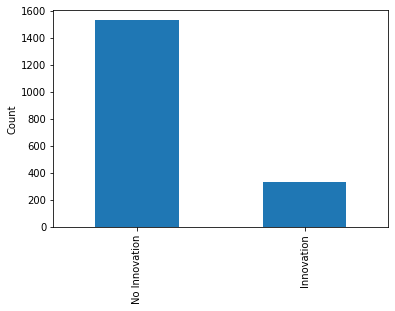

In [ ]:
y_train.value_counts().plot(kind='bar')
plt.xticks([0, 1], ['No Innovation', 'Innovation'])
plt.ylabel('Count')

In [ ]:
y_train: pd.DataFrame = pd.to_numeric(y_train)
y_test: pd.DataFrame = pd.to_numeric(y_test)

Train f1 Score: 0.9970238095238095
Test f1 Score: 0.9933774834437086


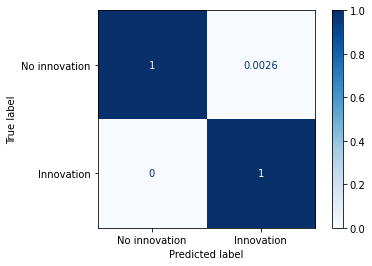

In [ ]:
# Logistic Regression Classifier
clf: LogisticRegression = LogisticRegression(max_iter=1000)

clf.fit(X_train, y_train)
y_hat_test: np.ndarray = clf.predict(X_test)
y_hat_train: np.ndarray = clf.predict(X_train)

train_f1: float = f1_score(y_train, y_hat_train)
test_f1: float = f1_score(y_test, y_hat_test)

print(f"Train f1 Score: {train_f1}")
print(f"Test f1 Score: {test_f1}")

# The beautiful checkerboard
plot_confusion_matrix(clf, X_test, y_test, cmap='Blues', normalize='true',
                      display_labels=['No innovation', 'Innovation'])

Train f1 Score: 0.591337099811676
Test f1 Score: 0.5


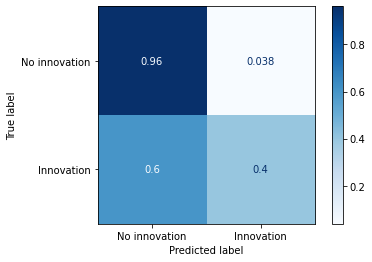

In [ ]:
# k Neighbors Classifier
knn: KNeighborsClassifier = KNeighborsClassifier()

knn.fit(X_train, y_train)
y_hat_test: np.ndarray = knn.predict(X_test)
y_hat_train: np.ndarray = knn.predict(X_train)

train_f1: float = f1_score(y_train, y_hat_train)
test_f1: float = f1_score(y_test, y_hat_test)

print(f"Train f1 Score: {train_f1}")
print(f"Test f1 Score: {test_f1}")

# The beautiful checkerboard
plot_confusion_matrix(knn, X_test, y_test, cmap='Blues', normalize='true',
                      display_labels=['No innovation', 'Innovation'])

Train f1 Score: 0.9209302325581395
Test f1 Score: 0.8759124087591241


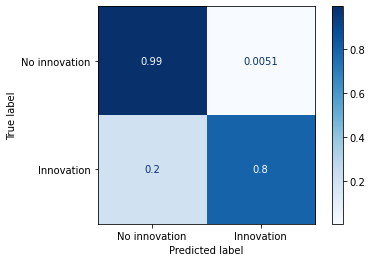

In [ ]:
# Support vector machine
svc = svm.SVC(C = 4,kernel='linear', probability= True)

svc.fit(X_train, y_train)
y_hat_test: np.ndarray = svc.predict(X_test)
y_hat_train: np.ndarray = svc.predict(X_train)

train_f1: float = f1_score(y_train, y_hat_train)
test_f1: float = f1_score(y_test, y_hat_test)

print(f"Train f1 Score: {train_f1}")
print(f"Test f1 Score: {test_f1}")

# The beautiful checkerboard
plot_confusion_matrix(svc, X_test, y_test, cmap='Blues', normalize='true',
                      display_labels=['No innovation', 'Innovation'])

Train f1 Score: 1.0
Test f1 Score: 0.9932885906040269


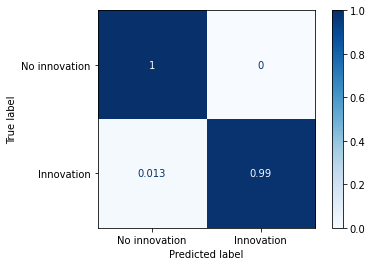

In [ ]:
# SGD classifier
clf = make_pipeline(StandardScaler(),
                    SGDClassifier(max_iter=1000, tol=1e-3, loss='log'))

clf.fit(X_train, y_train)
y_hat_test: np.ndarray = clf.predict(X_test)
y_hat_train: np.ndarray = clf.predict(X_train)

train_f1: float = f1_score(y_train, y_hat_train)
test_f1: float = f1_score(y_test, y_hat_test)

print(f"Train f1 Score: {train_f1}")
print(f"Test f1 Score: {test_f1}")

# The beautiful checkerboard
plot_confusion_matrix(clf, X_test, y_test, cmap='Blues', normalize='true',
                      display_labels=['No innovation', 'Innovation'])

In [ ]:
# Generate probabilities for each prediction
clf.predict_proba(X_test)

array([[9.99989556e-01, 1.04439483e-05],
       [9.99988970e-01, 1.10298671e-05],
       [9.99991749e-01, 8.25051944e-06],
       [9.99989459e-01, 1.05414621e-05],
       [9.99992672e-01, 7.32836298e-06],
       [9.99993516e-01, 6.48351495e-06],
       [5.54938444e-01, 4.45061556e-01],
       [9.99955776e-01, 4.42244128e-05],
       [9.99992848e-01, 7.15163523e-06],
       [9.99993378e-01, 6.62154181e-06],
       [9.99993474e-01, 6.52583100e-06],
       [0.00000000e+00, 1.00000000e+00],
       [9.99989920e-01, 1.00796784e-05],
       [9.99931875e-01, 6.81250843e-05],
       [1.33957144e-07, 9.99999866e-01],
       [9.77855087e-04, 9.99022145e-01],
       [9.99986677e-01, 1.33232851e-05],
       [9.99989890e-01, 1.01096993e-05],
       [1.08200052e-07, 9.99999892e-01],
       [9.99992884e-01, 7.11583444e-06],
       [9.99986742e-01, 1.32582325e-05],
       [9.99990138e-01, 9.86162077e-06],
       [9.99989235e-01, 1.07652102e-05],
       [9.99988277e-01, 1.17232305e-05],
       [9.999900

## After decision, train first classifier

we classify all the data for which the model is more than 99% certain of its response. We use 2 differents models to classifie with 99% safety and a last model differents of the first two with 50% of safety for classifie all the rest of data

In [ ]:
# Initiate iteration counter
iterations: int = 0

# Containers to hold f1_scores and # of pseudo-labels
train_f1s: list = []
test_f1s: list = []
pseudo_labels: list = []

# Assign value to initiate while loop
high_prob: list = [1]

# Loop will run until there are no more high-probability pseudo-labels
while len(high_prob) > 0:

    # Fit classifier and make train/test predictions
    log: LogisticRegression = LogisticRegression(C=1e5)
    log.fit(X_train, y_train)
    y_hat_train: np.ndarray = log.predict(X_train)
    y_hat_test: np.ndarray = log.predict(X_test)

    # Calculate and print iteration # and f1 scores, and store f1 scores
    train_f1: float = f1_score(y_train, y_hat_train)
    test_f1: float = f1_score(y_test, y_hat_test)
    print(f"Iteration {iterations}")
    print(f"Train f1: {train_f1}")
    print(f"Test f1: {test_f1}")
    train_f1s.append(train_f1)
    test_f1s.append(test_f1)

    if (len(X_unlabeled) > 0):
        # Generate predictions and probabilities for unlabeled data
        print(f"Now predicting labels for unlabeled data...")

        pred_probs: np.ndarray = log.predict_proba(X_unlabeled)
        preds: np.ndarray = log.predict(X_unlabeled)
        prob_0: list = pred_probs[:, 0]
        prob_1: list = pred_probs[:, 1]

        # Store predictions and probabilities in dataframe
        df_pred_prob: pd.DataFrame = pd.DataFrame([])
        df_pred_prob['preds']: pd.DataFrame = preds
        df_pred_prob['prob_0']: pd.DataFrame = prob_0
        df_pred_prob['prob_1']: pd.DataFrame = prob_1
        df_pred_prob.index: pd.DataFrame = X_unlabeled.index

        # Separate predictions with > 99% probability
        high_prob: pd.DataFrame = pd.concat([df_pred_prob.loc[df_pred_prob['prob_0'] > 0.99],
                                             df_pred_prob.loc[df_pred_prob['prob_1'] > 0.99]],
                                            axis=0)

        print(f"{len(high_prob)} high-probability predictions added to training data.")

        pseudo_labels.append(len(high_prob))

        # Add pseudo-labeled data to training data
        X_train: pd.DataFrame = pd.concat(
            [X_train, X_unlabeled.loc[high_prob.index]], axis=0)
        y_train: pd.DataFrame = pd.concat([y_train, high_prob.preds])

        # Drop pseudo-labeled instances from unlabeled data
        X_unlabeled: pd.DataFrame = X_unlabeled.drop(index=high_prob.index)
        print(f"{len(X_unlabeled)} unlabeled instances remaining.\n")

        # Update iteration counter
        iterations += 1
    else:
        high_prob: list = []
        print(f'end of process.')

Iteration 0
Train f1: 0.9985096870342772
Test f1: 1.0
Now predicting labels for unlabeled data...
5172 high-probability predictions added to training data.
26 unlabeled instances remaining.

Iteration 1
Train f1: 0.9997262523952916
Test f1: 1.0
Now predicting labels for unlabeled data...
0 high-probability predictions added to training data.
26 unlabeled instances remaining.



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



## Train Second classifier for the last unlabelled data

In [ ]:
# Initiate iteration counter
iterations: float = 0

# Containers to hold f1_scores and # of pseudo-labels
train_f1s: list = []
test_f1s: list = []
pseudo_labels: list = []

# Assign value to initiate while loop
high_prob: list = [1]

# Loop will run until there are no more high-probability pseudo-labels
while len(high_prob) > 0:

    # Fit classifier and make train/test predictions
    knn: KNeighborsClassifier = KNeighborsClassifier()
    knn.fit(X_train, y_train)
    y_hat_train: np.ndarray = knn.predict(X_train)
    y_hat_test: np.ndarray = knn.predict(X_test)

    # Calculate and print iteration # and f1 scores, and store f1 scores
    train_f1: float = f1_score(y_train, y_hat_train)
    test_f1: float = f1_score(y_test, y_hat_test)
    print(f"Iteration {iterations}")
    print(f"Train f1: {train_f1}")
    print(f"Test f1: {test_f1}")
    train_f1s.append(train_f1)
    test_f1s.append(test_f1)

    if (len(X_unlabeled) > 0):
        # Generate predictions and probabilities for unlabeled data
        print(f"Now predicting labels for unlabeled data...")

        pred_probs: np.ndarray = knn.predict_proba(X_unlabeled)
        preds: np.ndarray = knn.predict(X_unlabeled)
        prob_0: list = pred_probs[:, 0]
        prob_1: list = pred_probs[:, 1]

        # Store predictions and probabilities in dataframe
        df_pred_prob: pd.DataFrame = pd.DataFrame([])
        df_pred_prob['preds']: pd.DataFrame = preds
        df_pred_prob['prob_0']: pd.DataFrame = prob_0
        df_pred_prob['prob_1']: pd.DataFrame = prob_1
        df_pred_prob.index: pd.DataFrame = X_unlabeled.index

        # Separate predictions with > 99% probability
        high_prob: pd.DataFrame = pd.concat([df_pred_prob.loc[df_pred_prob['prob_0'] > 0.99],
                                             df_pred_prob.loc[df_pred_prob['prob_1'] > 0.99]],
                                            axis=0)

        print(f"{len(high_prob)} high-probability predictions added to training data.")

        pseudo_labels.append(len(high_prob))

        # Add pseudo-labeled data to training data
        X_train: pd.DataFrame = pd.concat(
            [X_train, X_unlabeled.loc[high_prob.index]], axis=0)
        y_train: pd.DataFrame = pd.concat([y_train, high_prob.preds])

        # Drop pseudo-labeled instances from unlabeled data
        X_unlabeled: pd.DataFrame = X_unlabeled.drop(index=high_prob.index)
        print(f"{len(X_unlabeled)} unlabeled instances remaining.\n")

        # Update iteration counter
        iterations += 1
    else:
        high_prob: list = []
        print(f'end of process.')

Iteration 0
Train f1: 0.7601572739187418
Test f1: 0.6071428571428572
Now predicting labels for unlabeled data...
14 high-probability predictions added to training data.
12 unlabeled instances remaining.

Iteration 1
Train f1: 0.7601572739187418
Test f1: 0.6071428571428572
Now predicting labels for unlabeled data...
0 high-probability predictions added to training data.
12 unlabeled instances remaining.



In [ ]:
# Plot f1 scores and number of pseudo-labels added for all iterations
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6, 8))
ax1.plot(range(iterations), test_f1s)
ax1.set_ylabel('f1 Score')
ax2.bar(x=range(iterations), height=pseudo_labels)
ax2.set_ylabel('Pseudo-Labels Created')
ax2.set_xlabel('# Iterations')

# View confusion matrix after self-training
plot_confusion_matrix(knn, X_test, y_test, cmap='Blues', normalize='true',
                      display_labels=['No Innovation', 'Innovation'])

## If needed, third classifier

In [ ]:
# Initiate iteration counter
iterations: int = 0

# Containers to hold f1_scores and # of pseudo-labels
train_f1s: list = []
test_f1s: list = []
pseudo_labels: list = []

# Assign value to initiate while loop
high_prob: list = [1]

# Loop will run until there are no more high-probability pseudo-labels
while len(high_prob) > 0:

    # Fit classifier and make train/test predictions
    clf = make_pipeline(StandardScaler(),
                        SGDClassifier(max_iter=1000, tol=1e-3, loss='log'))
    clf.fit(X_train, y_train)
    y_hat_train: np.ndarray = clf.predict(X_train)
    y_hat_test: np.ndarray = clf.predict(X_test)

    # Calculate and print iteration # and f1 scores, and store f1 scores
    train_f1: float = f1_score(y_train, y_hat_train)
    test_f1: float = f1_score(y_test, y_hat_test)
    print(f"Iteration {iterations}")
    print(f"Train f1: {train_f1}")
    print(f"Test f1: {test_f1}")
    train_f1s.append(train_f1)
    test_f1s.append(test_f1)

    if (len(X_unlabeled) > 0):
        # Generate predictions and probabilities for unlabeled data
        print(f"Now predicting labels for unlabeled data...")

        pred_probs: np.ndarray = clf.predict_proba(X_unlabeled)
        preds: np.ndarray = clf.predict(X_unlabeled)
        prob_0: list = pred_probs[:, 0]
        prob_1: list = pred_probs[:, 1]

        # Store predictions and probabilities in dataframe
        df_pred_prob: pd.DataFrame = pd.DataFrame([])
        df_pred_prob['preds']: pd.DataFrame = preds
        df_pred_prob['prob_0']: pd.DataFrame = prob_0
        df_pred_prob['prob_1']: pd.DataFrame = prob_1
        df_pred_prob.index: pd.DataFrame = X_unlabeled.index

        # Separate predictions with > 60% probability
        high_prob: pd.DataFrame = pd.concat([df_pred_prob.loc[df_pred_prob['prob_0'] > 0.60],
                                             df_pred_prob.loc[df_pred_prob['prob_1'] > 0.60]],
                                            axis=0)

        print(f"{len(high_prob)} high-probability predictions added to training data.")

        pseudo_labels.append(len(high_prob))

        # Add pseudo-labeled data to training data
        X_train: pd.DataFrame = pd.concat(
            [X_train, X_unlabeled.loc[high_prob.index]], axis=0)
        y_train: pd.DataFrame = pd.concat([y_train, high_prob.preds])

        # Drop pseudo-labeled instances from unlabeled data
        X_unlabeled: pd.DataFrame = X_unlabeled.drop(index=high_prob.index)
        print(f"{len(X_unlabeled)} unlabeled instances remaining.\n")

        # Update iteration counter
        iterations += 1
    else:
        high_prob: list = []
        print(f'end of process.')

Iteration 0
Train f1: 1.0
Test f1: 1.0
Now predicting labels for unlabeled data...
12 high-probability predictions added to training data.
0 unlabeled instances remaining.

Iteration 1
Train f1: 1.0
Test f1: 1.0
end of process.


##Recuperate data, analyse results and export results

In [ ]:
X_test['innovation_detection']: pd.DataFrame = y_test
test_end: pd.DataFrame = X_test

In [ ]:
X_train['innovation_detection']: pd.DataFrame = y_train
train_end: pd.DataFrame = X_train

In [ ]:
final: pd.DataFrame = pd.concat([train_end, test_end])

In [ ]:
final['index']: pd.DataFrame = final.index

In [ ]:
df_final: pd.DataFrame = pd.merge(
    left=df, right=final, left_on='index', right_on='index')

In [ ]:
df_final: pd.DataFrame = df_final.rename(columns={'art_id_x': 'art_id',
                                                  'innovation_detection_y': 'innovation_features'})

In [ ]:
data_acp: pd.DataFrame = df_final[['Nb_key_words_x', 'Nb_key_words_title_x',
                                   'ratio_key_words_x', 'ratio_key_word_title_x']]
y: pd.DataFrame = df_final['innovation_features']
dic_values: dict = {"Innovation": 1, "No Innovation": 0}

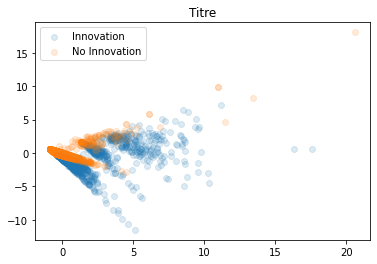

In [ ]:
# Graph 2D for see predictions
graph_2d(data_acp, y, dic_values)

In [ ]:
# Graph 3D for see predictions
graph_3d(data_acp, y, dic_values)

In [ ]:
df_final: pd.DataFrame = df_final[['art_id', 'innovation_features']]

In [ ]:
df_final.to_json(
    "/content/drive/MyDrive/G5 Inter-Promo 2021/Données/Output/Innovation/Res_Innovation_semi_supervised_V0.json")

## Results analysis

In [ ]:
v0: pd.DataFrame = pd.read_json(
    "/content/drive/MyDrive/G5 Inter-Promo 2021/Données/Output/Innovation/Res_Innovation_semi_supervised_Feature.json")

data0: pd.DataFrame = pd.read_csv(
    "/content/drive/MyDrive/G5 Inter-Promo 2021/Données/Input/Data_With_Features_Syntax.csv")

df0: pd.DataFrame = pd.merge(left=data0, right=v0, on='art_id')

df_innovant_v0: pd.DataFrame = df0[df0['innovation_features'] == 1].reset_index(
)
df_non_innovant_v0: pd.DataFrame = df0[df0['innovation_features'] == 0].reset_index(
)

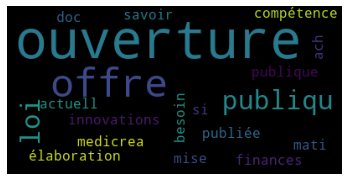

In [ ]:
# Word cloud of documents classifie as innovant
wordcloud_list_art(df_innovant_v0.loc[:len(df_innovant_v0), "art_content"])

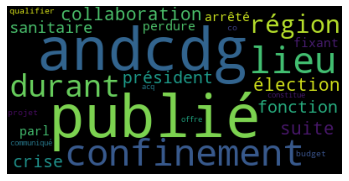

In [ ]:
# Word cloud of documents classifie as non innovant
wordcloud_list_art(df_non_innovant_v0.loc[:len(
    df_non_innovant_v0), "art_content"])